In [1]:
# standar libraries
import os
import sys

# third-party libraries
from typing import Tuple
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    ConfusionMatrixDisplay,
)
from sklearn.tree import plot_tree
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.postprocessing import RejectOptionClassification
from sklearn.preprocessing import LabelEncoder

# local module
sys.path.append(os.path.abspath(".."))
from project_config import from_root

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
ADRESS_TRAIN_FEATURE_FILE = from_root("data", "features", "adress_train_features.tsv")
ADRESS_TEST_FEATURE_FILE = from_root("data", "features", "adress_test_features.tsv")
ADRESS_SAVE_MODEL_AS = from_root("output", "models", "rf_model_adress.pkl")
ADRESS_PREDICTIONS_OUTPUT_FILE = from_root("output", "predictions", "adress_test_predictions.tsv")
ADRESS_REDUCED_TEST_FEATURES_FILE = from_root("data", "features", "adress_test_features_reduced.tsv")
ADRESS_N_ESTIMATORS = 100
ADRESS_RANDOM_STATE = 42
# privileged -> female (0) and age >= 65 (1)
# unprivileged -> male (1) and age < 65 (0)
PROTECTED_GROUPS = {
    "gender_bin": {"privileged": 0, "unprivileged": 1},
    "age_group_65": {"privileged": 1, "unprivileged": 0},
} # for the fairness evaluation later on

def load_adress_data(
    train_path: str, 
    test_path: str
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame]:
    df_train = pd.read_csv(train_path, sep="\t").dropna(subset=["label"])
    df_test = pd.read_csv(test_path, sep="\t")
    # drop the metadata columns from training set
    metadata_cols = ["ID", "label", "gender", "age"]
    X_train = df_train.drop(columns=metadata_cols, errors='ignore')
    y_train = df_train["label"]
    X_test = df_test.drop(columns=metadata_cols, errors='ignore')
    ids_test = df_test["ID"]

    return X_train, y_train, X_test, ids_test, df_test  # df_test for fairness later


def main_adress_topk(top_k: int) -> Tuple[RandomForestClassifier, pd.DataFrame]:
    X_train, y_train, X_test, ids_test, df_test = load_adress_data(
        ADRESS_TRAIN_FEATURE_FILE, 
        ADRESS_TEST_FEATURE_FILE
    )
    # print(f"Original number of features: {X_train.shape[1]}")

    base_model = RandomForestClassifier(n_estimators=ADRESS_N_ESTIMATORS, 
                                        random_state=ADRESS_RANDOM_STATE, 
                                        class_weight='balanced'
    )
    base_model.fit(X_train, y_train)

    importances = base_model.feature_importances_
    top_k_indices = np.argsort(importances)[-top_k:]
    top_k_features = X_train.columns[top_k_indices]

    # for ablatino study 
    # top_k_features = top_k_features.drop("honore_statistic", errors='ignore')

    print(f"Top-{top_k} Features:\n", top_k_features.tolist())

    # save top-k features
    X_train_reduced = X_train[top_k_features]
    X_test_reduced = X_test[top_k_features]
    reduced_df = pd.DataFrame(X_test_reduced)
    reduced_df.insert(0, "ID", ids_test)
    reduced_df.to_csv(ADRESS_REDUCED_TEST_FEATURES_FILE, sep="\t", index=False)

    # retrain final model with top-k features
    final_model = RandomForestClassifier(n_estimators=ADRESS_N_ESTIMATORS,
                                         random_state=ADRESS_RANDOM_STATE,
                                         class_weight='balanced')
    final_model.fit(X_train_reduced, y_train)
    joblib.dump(final_model, ADRESS_SAVE_MODEL_AS)

    preds = final_model.predict(X_test_reduced)
    predictions_df = pd.DataFrame({"ID": ids_test, "predicted_label": preds})
    predictions_df.to_csv(ADRESS_PREDICTIONS_OUTPUT_FILE, sep="\t", index=False)

    # heatmap
    corr = X_train_reduced.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, mask = mask, annot=True, fmt=".2f", cmap="coolwarm", 
                square=True, cbar=True, linewidths=0.5)
    # plt.title(f"ADReSS Top-{top_k} Feature Correlation Heatmap", fontsize=14)
    plt.tight_layout()
    plot_path = from_root(
        "output", "plots", f"top_{top_k}_feature_correlation_heatmap.png"
    )
    plt.savefig(plot_path)
    plt.show()

    return final_model, X_train_reduced


def evaluate_adress_topk() -> None:
    preds = pd.read_csv(ADRESS_PREDICTIONS_OUTPUT_FILE, sep="\t")
    test_features = pd.read_csv(ADRESS_REDUCED_TEST_FEATURES_FILE, sep="\t")
    true_labels = pd.read_csv(from_root("data", "raw", "labels.tsv"), sep="\t")

    # X = test_features.drop(columns=["ID"])
    # print(f"Number of features in reduced test set: {X.shape[1]}")

    preds = preds.sort_values("ID").reset_index(drop=True)
    test_features = test_features.sort_values("ID").reset_index(drop=True)
    true_labels = true_labels.sort_values("ID").reset_index(drop=True)
    
    y_true = true_labels["Label"].astype(int)
    y_pred = preds["predicted_label"]
    
    print("\n--- ADReSS Evaluation ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred, digits=3))
    
    # ROC-AUC
    model = joblib.load(ADRESS_SAVE_MODEL_AS)
    # for ablation study
    X = test_features.drop(columns=["ID"])
    # X = test_features.drop(columns=["ID", "honore_statistic"], errors='ignore')
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    print(f"ROC-AUC: {roc_auc:.3f}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ADReSS ROC (AUC = {roc_auc:.2f})", color='blue')
    plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
    plt.title("ROC Curve ADReSS")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path = from_root("output", "plots", "adress_roc_curve.png")
    plt.savefig(plot_path)
    plt.show()

In [3]:
# =============================================================================
# NOTE: this cell is for reporting the dataset distribution you can skip it 
# if you are not interested in the dataset distribution
# =============================================================================


def describe_adress_dataset(train_path, test_path, label_path):
    df_train = pd.read_csv(train_path, sep="\t")
    df_test = pd.read_csv(test_path, sep="\t")
    df_labels = pd.read_csv(label_path, sep="\t")

    print("ADReSS Dataset Summary")
    print(f"Training samples: {len(df_train)}")
    print(f"Test samples:     {len(df_test)}")

    if "label" in df_train.columns:
        print("Training set label distribution:")
        print(df_train["label"].value_counts())

    if "Label" in df_labels.columns:
        print("Test set label distribution (from labels.tsv):")
        print(df_labels["Label"].value_counts())

    token_col = None
    for col in df_train.columns:
        if "word" in col.lower() or "token" in col.lower():
            token_col = col
            break

    if token_col:
        print(f"\nAverage {token_col} in training set: {df_train[token_col].mean():.1f} ± {df_train[token_col].std():.1f}")
        print(f"Average {token_col} in test set: {df_test[token_col].mean():.1f} ± {df_test[token_col].std():.1f}")
    else:
        print("\nNo token/word count found in feature file.")

describe_adress_dataset(
    ADRESS_TRAIN_FEATURE_FILE,
    ADRESS_TEST_FEATURE_FILE,
    from_root("data", "raw", "labels.tsv")
)

ADReSS Dataset Summary
Training samples: 108
Test samples:     48
Training set label distribution:
label
1    54
0    54
Name: count, dtype: int64
Test set label distribution (from labels.tsv):
Label
0    24
1    24
Name: count, dtype: int64

Average word_count in training set: 110.6 ± 63.2
Average word_count in test set: 118.5 ± 81.7


Top-18 Features:
 ['type_token_ratio', 'noun_verb_ratio', 'word_count', 'stopword_ratio', 'mean_sentence_length', 'compression_ratio', 'verb_ratio', 'mattr', 'prep_ratio', 'IU_count', 'unique_words', 'IU_density', 'noun_ratio', 'content_density', 'pronoun_ratio', 'adv_ratio', 'honore_statistic', 'auxiliary_ratio']


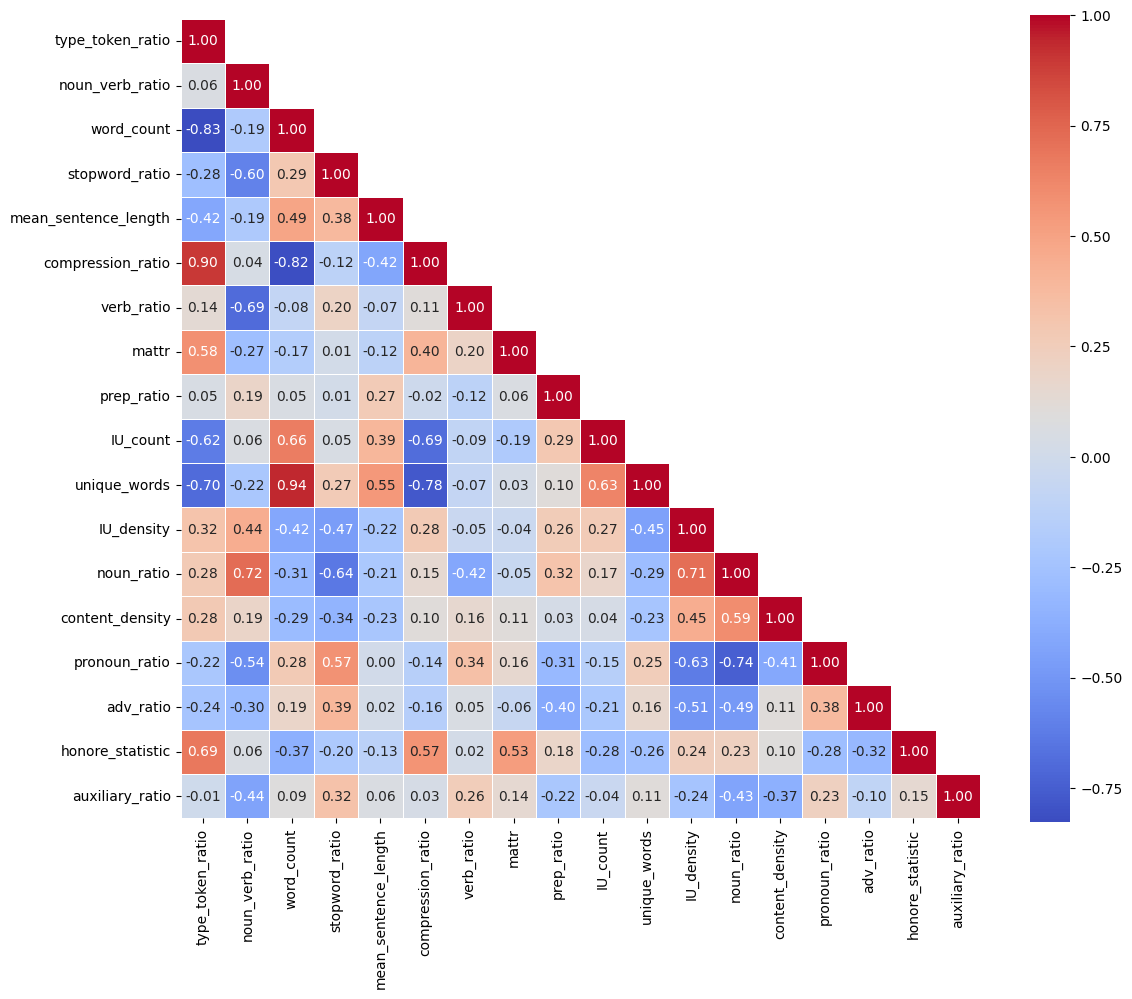


--- ADReSS Evaluation ---
Accuracy: 0.833
              precision    recall  f1-score   support

           0      0.786     0.917     0.846        24
           1      0.900     0.750     0.818        24

    accuracy                          0.833        48
   macro avg      0.843     0.833     0.832        48
weighted avg      0.843     0.833     0.832        48

ROC-AUC: 0.889


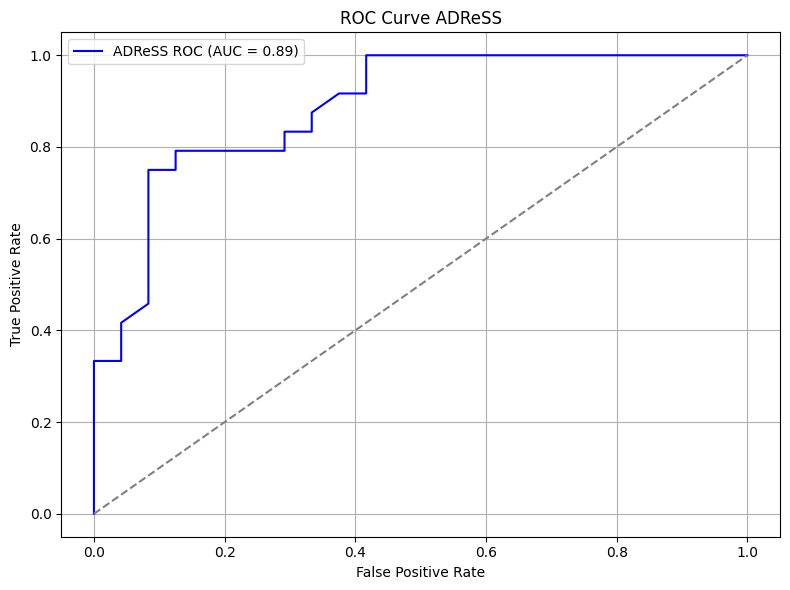

In [4]:
main_adress_topk(top_k=18)
evaluate_adress_topk()

In [5]:
def shap_plots() -> None:
    output_dir = from_root("output", "shap", "shap_adress")
    os.makedirs(output_dir, exist_ok=True)
    # load model and test data
    model = joblib.load(from_root("output", "models", "rf_model_adress.pkl"))
    test_features = pd.read_csv(from_root("data", "features", "adress_test_features_reduced.tsv"), sep="\t")
    X_test = test_features.drop(columns=["ID"]).reset_index(drop=True)

    pred_prob = model.predict_proba(X_test)[:, 1]
    pred_labels = model.predict(X_test)

    results_df = pd.DataFrame({
        "ID": test_features["ID"],
        "predicted_label": pred_labels,
        "predicted_probability": pred_prob
    })

    # print(results_df)
    # test_labels = pd.read_csv(from_root("data", "raw", "labels.tsv"), sep="\t")

    # SHAP explainer and values 
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)

    # get SHAP values for AD (1) 
    shap_values_ad = shap.Explanation(
        values=shap_values.values[:, :, 1],                   
        base_values=shap_values.base_values[:, 1],            
        data=shap_values.data,
        feature_names=shap_values.feature_names)

    # SHAP bar plot
    plt.figure()
    shap.plots.bar(shap_values_ad, show=False)
    # plt.title("SHAP Bar Plot for ADReSS RF Model")
    plot_path = os.path.join(output_dir, "shap_barplot_adress_rf.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

    # SHAP beeswarm plot
    plt.figure()
    shap.plots.beeswarm(shap_values_ad, show=False)
    # plt.title("SHAP Beeswarm Plot for ADReSS RF Model")
    plot_path = os.path.join(output_dir, "shap_beeswarm_adress_rf.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

    instance_index = 0  # change it to visualize different instances
    instance_features = X_test.iloc[instance_index]
    instance_id = test_features.iloc[instance_index]["ID"]

    # get prob
    # instance_features_df = instance_features.to_frame().T
    # instance_prob = model.predict_proba(instance_features_df)[0][1]
    # pred_label = model.predict(instance_features_df)[0]
    # true_label = test_labels.loc[instance_index]["Label"]

    # print(f'\nWaterfall plot info')
    # print(f'Instance ID: {instance_id}')
    # print(f'Predicted Probability: {instance_prob:.2f}')
    # print(f'Predicted Label: {pred_label} (Probability: {instance_prob:.2f})')
    # print(f'True Label: {true_label}')

    print(f"\nInstance index: {instance_index}")
    print("Feature values for the instance:")
    print(instance_features)
    full_test_features = pd.read_csv(from_root("data", "adress_test.tsv"), sep="\t")
    transcript_row = full_test_features.loc[full_test_features["ID"] == instance_id, "transcription"]
    print(f"\nTranscript:\n")
    print(transcript_row.values[0])
    
           
    # SHAP waterfall plot
    plt.figure()
    shap.plots.waterfall(shap_values_ad[instance_index], show=False)
    # plt.title("SHAP Waterfall Plot for ADReSS RF Model")
    plot_path = os.path.join(output_dir, "shap_waterfall_adress_rf.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

    #SHAP by feature category
    feature_categories = {
        "lexical": ["word_count", "unique_words", "type_token_ratio", "honore_statistic", "brunet_index", "mattr", "compression_ratio"],
        "semantic": ["idea_density", "IU_count", "IU_density", "named_entity_count"],
        "syntactic": ["noun_ratio", "verb_ratio", "prep_ratio", "adv_ratio", "auxiliary_ratio", "parse_tree_depth", "clauses_per_sentence", "noun_verb_ratio", "mean_sentence_length"],
        "pragmatic": ["pronoun_ratio", "first_person_ratio", "third_person_ratio", "stopword_ratio", "repetition_score"],
        "CFG": ["cfg_np_to_nn", "cfg_np_to_det_noun"],
        "disfluency": ["pause_count", "utterance_count", "disfluency_count"]
    }

    shap_df = pd.DataFrame(shap_values_ad.values, columns=X_test.columns)
    # calculate mean absolute SHAP by category
    category_shap = {}
    for category, features in feature_categories.items():
        valid_feats = []
        for f in features:
            if f in shap_df.columns:
                valid_feats.append(f)
        if valid_feats:
            category_shap[category] = shap_df[valid_feats].abs().mean(axis=1).mean()

    # plot category-wise SHAP
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(category_shap.values()), y=list(category_shap.keys()))
    # plt.title("Mean Absolute SHAP Values by Feature Category for ADReSS RF Model")
    plt.xlabel("Mean |SHAP| Value")
    plt.ylabel("Feature Category")
    plt.tight_layout()
    plot_path = os.path.join(output_dir, "shap_category_importance_adress_rf.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

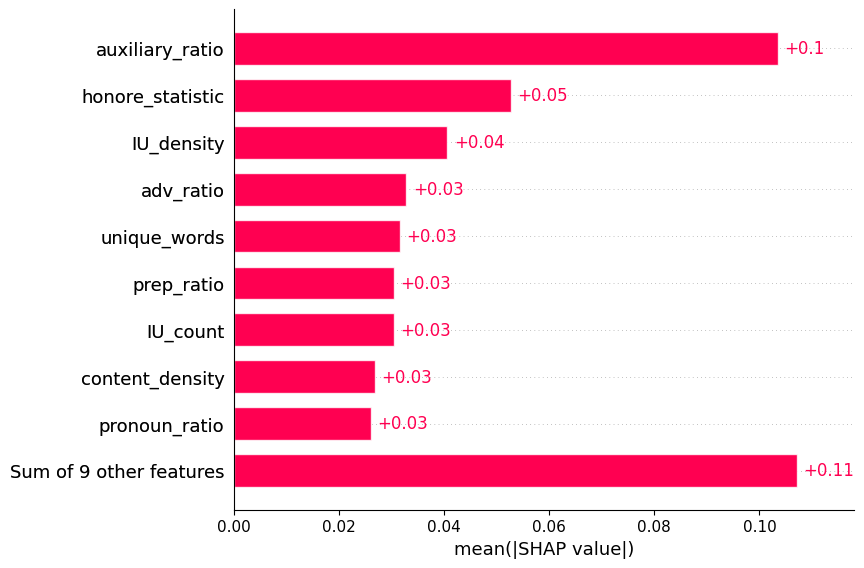

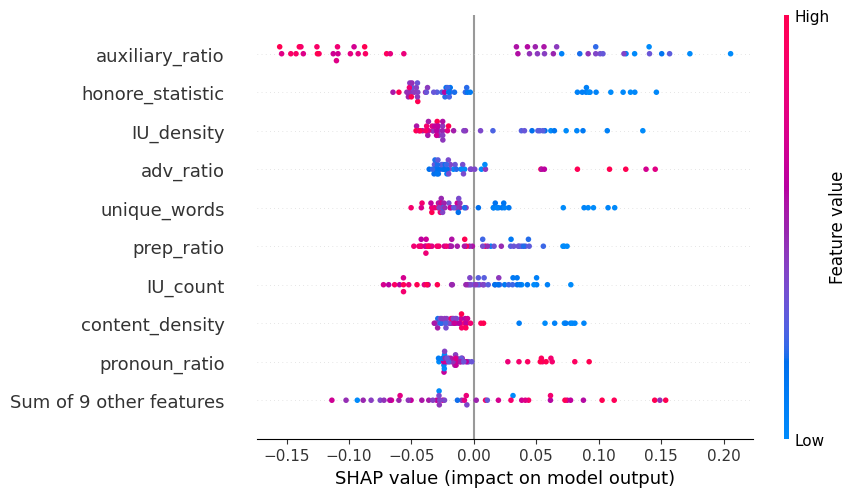


Instance index: 0
Feature values for the instance:
type_token_ratio           0.532710
noun_verb_ratio            2.000000
word_count               107.000000
stopword_ratio             0.598131
mean_sentence_length       8.230769
compression_ratio          0.513944
verb_ratio                 0.084112
mattr                      0.687586
prep_ratio                 0.130841
IU_count                   6.000000
unique_words              57.000000
IU_density                 0.056075
noun_ratio                 0.168224
content_density            0.317757
pronoun_ratio              0.158879
adv_ratio                  0.037383
honore_statistic        1210.687471
auxiliary_ratio            0.102804
Name: 0, dtype: float64

Transcript:

mhm . hm well sh shes um spillin the water from from washin uh her dishes . its its runnin over rather . in the the youngsters are are uh getting the jam . and in the meantime hes tiltin his chair laughs . hm ? he is hes hes trying to get the cake down where sh 

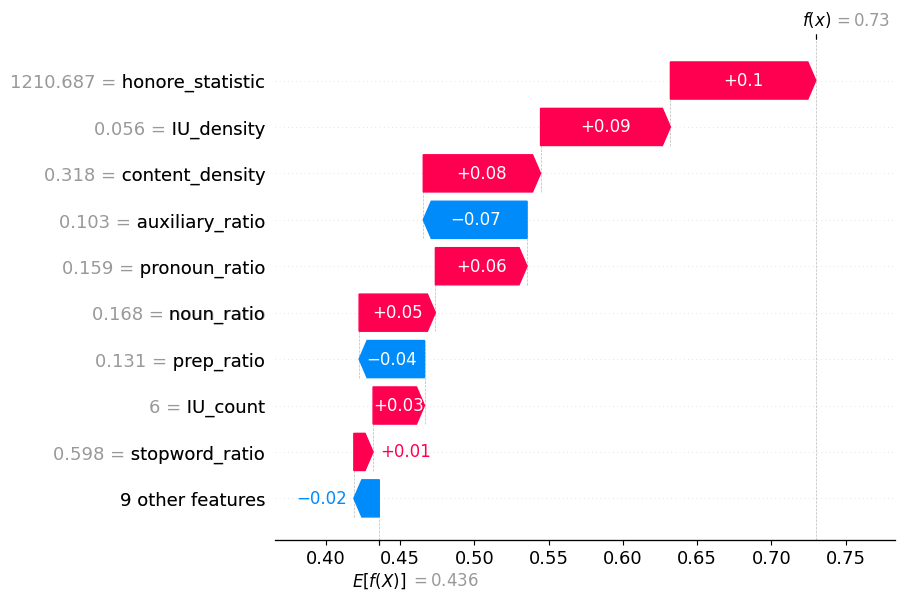

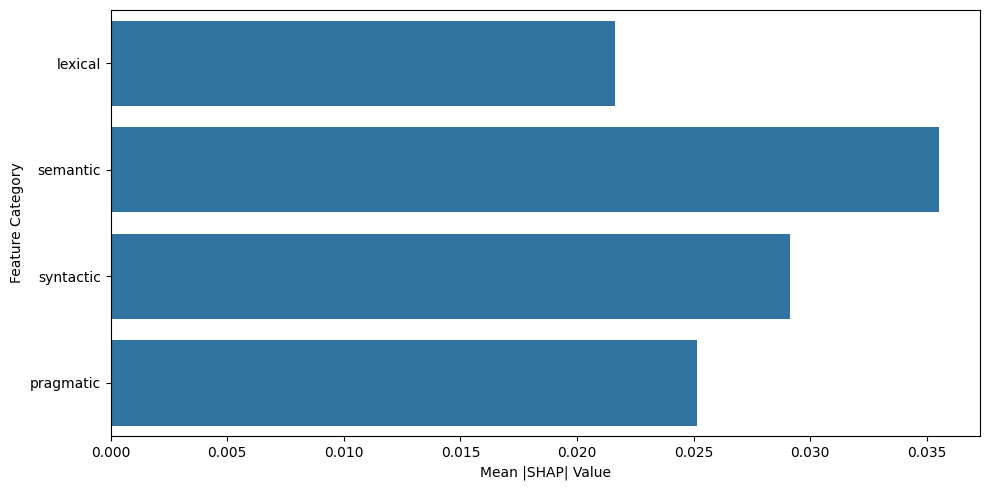

In [6]:
shap_plots()

Pearson correlation between Honore Statistic and Age: -0.044


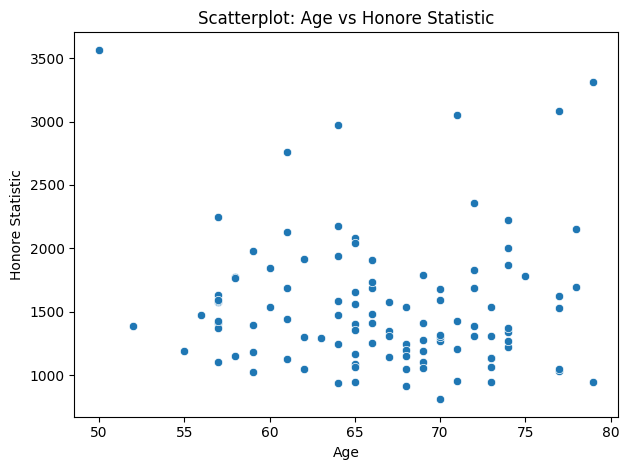

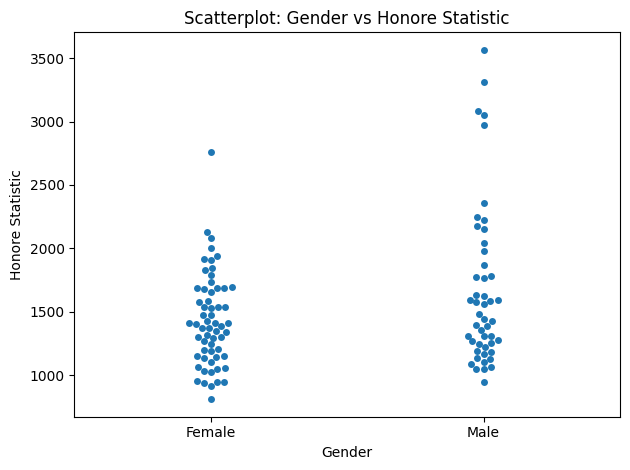

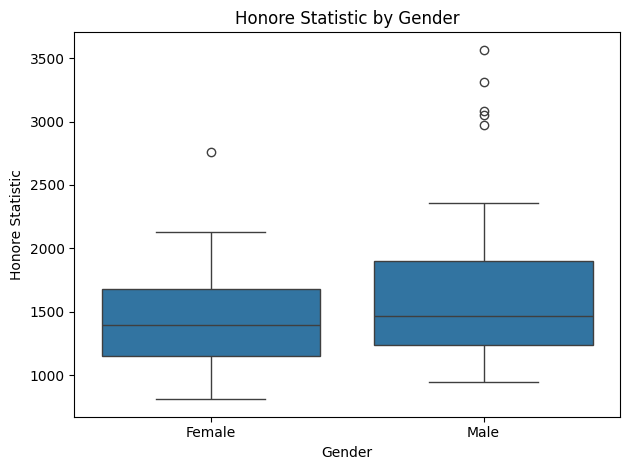

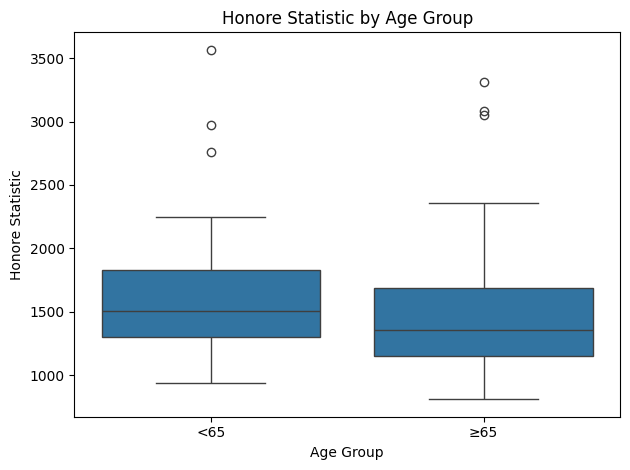

T-test between genders: t=-2.342, p=0.0220
T-test between age groups: t=1.431, p=0.1570


In [7]:
df_train = pd.read_csv(ADRESS_TRAIN_FEATURE_FILE, sep="\t")
df_train = df_train.dropna(subset=["honore_statistic", "age", "gender"])

correlation = df_train["honore_statistic"].corr(df_train["age"])
print(f"Pearson correlation between Honore Statistic and Age: {correlation:.3f}")

sns.scatterplot(x="age", y="honore_statistic", data=df_train)
plt.title("Scatterplot: Age vs Honore Statistic")
plt.xlabel("Age")
plt.ylabel("Honore Statistic")
plt.tight_layout()
plt.show()

df_train["gender_label"] = df_train["gender"].map({"f": "Female", "m": "Male"})
sns.swarmplot(
    x="gender_label", 
    y="honore_statistic", 
    data=df_train
)
plt.title("Scatterplot: Gender vs Honore Statistic")
plt.xlabel("Gender")
plt.ylabel("Honore Statistic")
plt.tight_layout()
plt.show()


sns.boxplot(x="gender_label", y="honore_statistic", data=df_train)
plt.title("Honore Statistic by Gender")
plt.xlabel("Gender")
plt.ylabel("Honore Statistic")
plt.tight_layout()
plt.show()


df_train["age_group_65"] = (df_train["age"] >= 65).astype(int)
df_train["age_group_label"] = df_train["age_group_65"].map({0: "<65", 1: "≥65"})

sns.boxplot(x="age_group_label", y="honore_statistic", data=df_train, order=["<65", "≥65"])
plt.title("Honore Statistic by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Honore Statistic")
plt.tight_layout()
plt.show()

# t-test b/w gender groups

group_f = df_train[df_train["gender"] == 'f']["honore_statistic"].dropna()
group_m = df_train[df_train["gender"] == 'm']["honore_statistic"].dropna()


t_stat, p_val = ttest_ind(group_f, group_m, equal_var=False)
print(f"T-test between genders: t={t_stat:.3f}, p={p_val:.4f}")

# t-test b/w age groups
group_young = df_train[df_train["age_group_65"] == 0]["honore_statistic"].dropna()
group_old = df_train[df_train["age_group_65"] == 1]["honore_statistic"].dropna()
t_stat_age, p_val_age = ttest_ind(group_young, group_old, equal_var=False)
print(f"T-test between age groups: t={t_stat_age:.3f}, p={p_val_age:.4f}")

In [8]:
def plot_rf_visualizations(
    model: RandomForestClassifier,
    X_test: pd.DataFrame,
    max_depth: int = 3,
    fontsize: int = 10
) -> None:
    # feature importance plot
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = X_test.columns[sorted_idx]
    sorted_importances = importances[sorted_idx]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_importances, y=sorted_features)
    plt.title("Feature Importance - ADReSS")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plot_path = from_root("output", "plots", "rf_feature_importance_adress.png")
    plt.savefig(plot_path)
    plt.show()

    # tree plot (1st tree)
    plt.figure(figsize=(20, 15))
    plot_tree(model.estimators_[0],
            feature_names=X_test.columns,
            class_names=["Control", "AD"],
            filled=True,
            rounded=True,
            max_depth=max_depth,
            fontsize=fontsize
    )
    # plt.title("First Tree from ADReSS RF Model")
    plt.tight_layout()
    plot_path = from_root("output", "plots", "rf_tree_adress.png")
    plt.savefig(plot_path)
    plt.show()

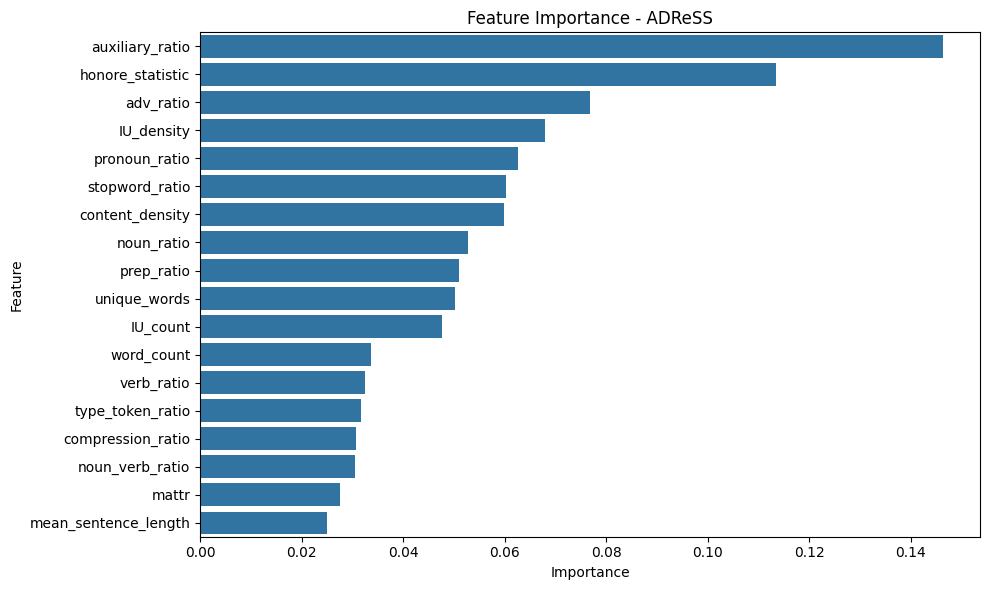

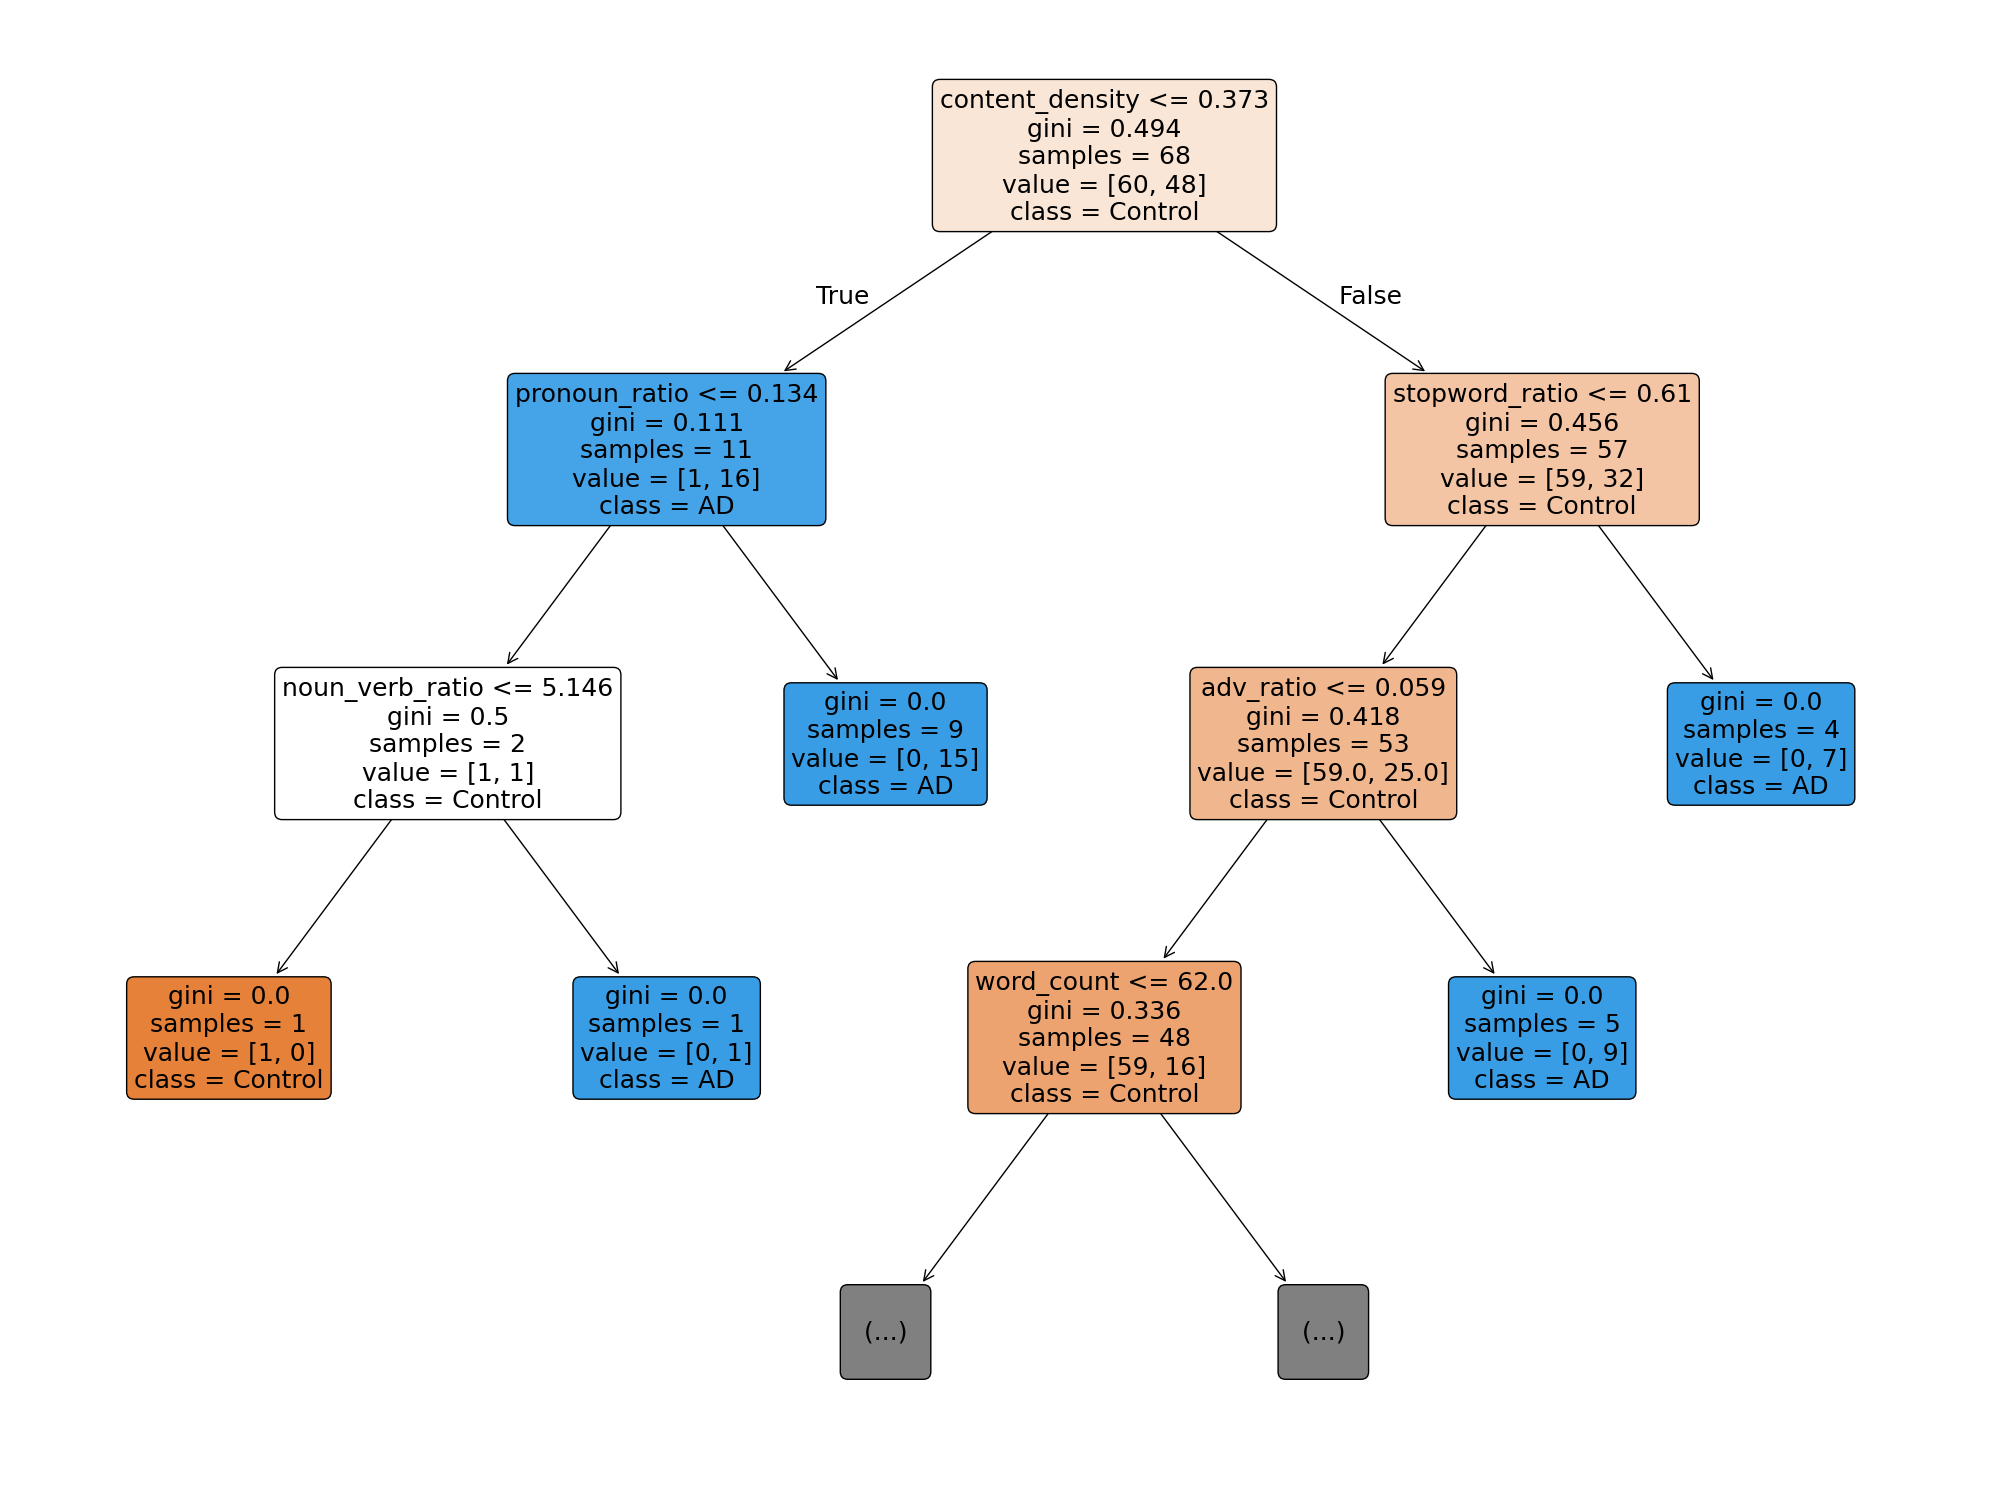

In [9]:
plot_rf_visualizations(
    model=joblib.load(ADRESS_SAVE_MODEL_AS),
    X_test=pd.read_csv(ADRESS_REDUCED_TEST_FEATURES_FILE, sep="\t").drop(columns=["ID"]),
    max_depth=3,
    fontsize=18
)

In [10]:
def load_and_prepare_fairness_data() -> pd.DataFrame:
    preds = pd.read_csv(from_root("output", "predictions", "adress_test_predictions.tsv"), sep="\t")
    true_labels = pd.read_csv(from_root("data", "raw", "labels.tsv"), sep="\t")
    metadata = pd.read_csv(from_root("data", "adress_test.tsv"), sep="\t")

    # clean and sort
    true_labels["ID"] = true_labels["ID"].str.strip()
    preds = preds.sort_values("ID").reset_index(drop=True)
    true_labels = true_labels.sort_values("ID").reset_index(drop=True)
    metadata = metadata.sort_values("ID").reset_index(drop=True)

    # merge them on ID
    df = preds.merge(true_labels, on="ID").merge(metadata[["ID", "gender", "age"]], on="ID")

    df["Label"] = df["Label"].astype(int)
    df["predicted_label"] = df["predicted_label"].astype(int)

    le = LabelEncoder()
    df["gender_bin"] = le.fit_transform(df["gender"].astype(str))  # maps gender to binary
    df["age_group_65"] = (df["age"] >= 65).astype(int)  # binary age group

    return df


def safe_metric(name: str, func) -> str:
    try:
        value = func()
        if not np.isnan(value):
            return f"{value:.3f}"
        else:
            return "N/A"
    except Exception:
        return "N/A"

def compute_fairness_metrics(
    df: pd.DataFrame,
    protected_attr: str,
    privileged_val: int,
    unprivileged_val: int,
    label_col: str = "Label"
) -> None:
    
    aif_data = BinaryLabelDataset(
        df=df[[label_col, protected_attr]].copy(),
        label_names=[label_col],
        protected_attribute_names=[protected_attr]
    )

    aif_pred = aif_data.copy()
    aif_pred.labels = df["predicted_label"].values.reshape(-1, 1)

    metric = ClassificationMetric(
        aif_data, aif_pred,
        privileged_groups=[{protected_attr: privileged_val}],
        unprivileged_groups=[{protected_attr: unprivileged_val}]
    )

    print(f"\nFairness Metrics for {protected_attr.upper()}:")
    print(f"    Statistical Parity Difference: {safe_metric('SPD', metric.statistical_parity_difference)}")
    print(f"    Equal Opportunity Difference:  {safe_metric('EOD', metric.equal_opportunity_difference)}")
    print(f"    Average Odds Difference:       {safe_metric('AOD', metric.average_odds_difference)}")
    print(f"    Disparate Impact:              {safe_metric('DI', metric.disparate_impact)}")

def evaluate_all_fairness_metrics_adress() -> None:
    df = load_and_prepare_fairness_data()
    
    for attr, vals in PROTECTED_GROUPS.items():
        compute_fairness_metrics(
            df,
            protected_attr=attr,
            privileged_val=vals["privileged"],
            unprivileged_val=vals["unprivileged"]
        )

In [11]:
evaluate_all_fairness_metrics_adress()


Fairness Metrics for GENDER_BIN:
    Statistical Parity Difference: -0.014
    Equal Opportunity Difference:  -0.042
    Average Odds Difference:       -0.014
    Disparate Impact:              0.967

Fairness Metrics for AGE_GROUP_65:
    Statistical Parity Difference: 0.222
    Equal Opportunity Difference:  0.222
    Average Odds Difference:       0.222
    Disparate Impact:              1.667


In [12]:
def apply_roc_and_plot(
    df: pd.DataFrame,
    group_col: str,
    group_name: str,
    privileged_val: int,
    unprivileged_val: int,
    save_prefix: str
) -> np.ndarray:
    aif_data = BinaryLabelDataset(
        df=df[["Label", group_col]].copy(),
        label_names=["Label"],
        protected_attribute_names=[group_col],
        favorable_label=1,
        unfavorable_label=0
    )

    aif_pred = aif_data.copy()
    aif_pred.scores = df["predicted_proba"].values.reshape(-1, 1)
    aif_pred.labels = df["predicted_label"].values.reshape(-1, 1)

    roc = RejectOptionClassification(
        unprivileged_groups=[{group_col: unprivileged_val}],
        privileged_groups=[{group_col: privileged_val}],
        metric_name="Statistical parity difference",
        metric_ub=0.01,
        metric_lb=-0.01
    ).fit(aif_data, aif_pred)

    fair_pred = roc.predict(aif_pred)

    # fairness metrics
    metric = ClassificationMetric(
        aif_data, fair_pred,
        privileged_groups=[{group_col: privileged_val}],
        unprivileged_groups=[{group_col: unprivileged_val}]
    )

    print(f"\nFairness Metrics for {group_name.upper()}:")
    print(f"    Accuracy before ROC:           {accuracy_score(df['Label'], df['predicted_label']):.3f}")
    print(f"    Accuracy after ROC:            {accuracy_score(df['Label'], fair_pred.labels.ravel()):.3f}")
    print(f"    Statistical Parity Difference: {safe_metric('SPD', metric.statistical_parity_difference)}")
    print(f"    Equal Opportunity Difference:  {safe_metric('EOD', metric.equal_opportunity_difference)}")
    print(f"    Average Odds Difference:       {safe_metric('AOD', metric.average_odds_difference)}")
    print(f"    Disparate Impact:              {safe_metric('DI', metric.disparate_impact)}")

    # confusion matrices
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    ConfusionMatrixDisplay(confusion_matrix(df["Label"], df["predicted_label"]),
                           display_labels=[0, 1]).plot(ax=axs[0])
    axs[0].set_title("Original Predictions")
    ConfusionMatrixDisplay(confusion_matrix(df["Label"], fair_pred.labels.ravel()),
                           display_labels=[0, 1]).plot(ax=axs[1])
    axs[1].set_title("ROC Fair Predictions")
    plt.suptitle(f"ADReSS {group_name} Mitigation")
    plt.tight_layout()
    plt.savefig(from_root("output", "fairness", f"roc_cm_{save_prefix}_adress_rf.png"))
    plt.show()

    # ROC margin sweep -> fairness - accuracy trade-off (2nd RQ)
    margins = range(1, 30, 2)
    spds, accs = [], []

    for m in margins:
        sweep = RejectOptionClassification(
            unprivileged_groups=[{group_col: unprivileged_val}],
            privileged_groups=[{group_col: privileged_val}],
            metric_name="Statistical parity difference",
            metric_ub=0.01,
            metric_lb=-0.01,
            num_ROC_margin=m
        ).fit(aif_data, aif_pred)

        pred = sweep.predict(aif_pred)
        mtr = ClassificationMetric(
            aif_data, pred,
            privileged_groups=[{group_col: privileged_val}],
            unprivileged_groups=[{group_col: unprivileged_val}]
        )

        spds.append(mtr.statistical_parity_difference())
        accs.append(accuracy_score(df["Label"], pred.labels.ravel()))

    plt.figure(figsize=(10, 5))
    plt.plot(margins, accs, label="Accuracy", marker="o")
    plt.plot(margins, spds, label="SPD", marker="x")
    plt.axhline(0.01, color="gray", linestyle="--", label="Fairness Bound")
    plt.axhline(-0.01, color="gray", linestyle="--")
    plt.xlabel("ROC Margin")
    plt.ylabel("Metric Value")
    plt.title(f"ADReSS ROC Margin Sweep - {group_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(from_root("output", "fairness", f"roc_margin_sweep_{save_prefix}_adress_rf.png"))
    plt.show()

    return fair_pred.labels.ravel()



def run_roc_fairness_adress() -> pd.DataFrame:
    preds = pd.read_csv(from_root("output", "predictions", "adress_test_predictions.tsv"), sep="\t")
    true_labels = pd.read_csv(from_root("data", "raw", "labels.tsv"), sep="\t")
    features = pd.read_csv(from_root("data", "features", "adress_test_features_reduced.tsv"), sep="\t")
    metadata = pd.read_csv(from_root("data", "adress_test.tsv"), sep="\t")

    # clean and sort
    preds = preds.rename(columns={"predicted_label": "pred_label"})
    true_labels = true_labels.rename(columns={"Label": "true_label"})
    true_labels["ID"] = true_labels["ID"].str.strip()

    df = preds.merge(true_labels, on="ID").merge(metadata[["ID", "gender", "age"]], on="ID")

    # load model and predict probabilities
    X_test = features.drop(columns=["ID"])
    model = joblib.load(from_root("output", "models", "rf_model_adress.pkl"))
    df["predicted_proba"] = model.predict_proba(X_test)[:, 1]

    df["Label"] = df["true_label"].astype(int)
    df["predicted_label"] = df["pred_label"].astype(int)
    df["gender_bin"] = LabelEncoder().fit_transform(df["gender"].astype(str))
    df["age_group_65"] = (df["age"] >= 65).astype(int)

    # apply ROC fairness for gender and age group
    df["ROC_gender_label"] = apply_roc_and_plot(
        df, 
        "gender_bin", 
        "Gender", 
        privileged_val=0, 
        unprivileged_val=1, 
        save_prefix="gender"
    )
    df["ROC_age_label"] = apply_roc_and_plot(
        df, 
        "age_group_65", 
        "Age 65+", 
        privileged_val=1, 
        unprivileged_val=0, 
        save_prefix="age"
    )

    return df


Fairness Metrics for GENDER:
    Accuracy before ROC:           0.833
    Accuracy after ROC:            0.833
    Statistical Parity Difference: 0.000
    Equal Opportunity Difference:  -0.028
    Average Odds Difference:       0.000
    Disparate Impact:              1.000


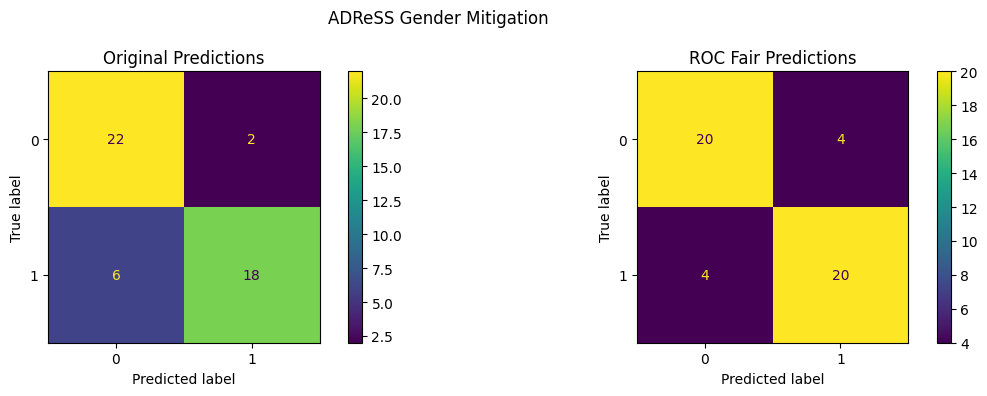

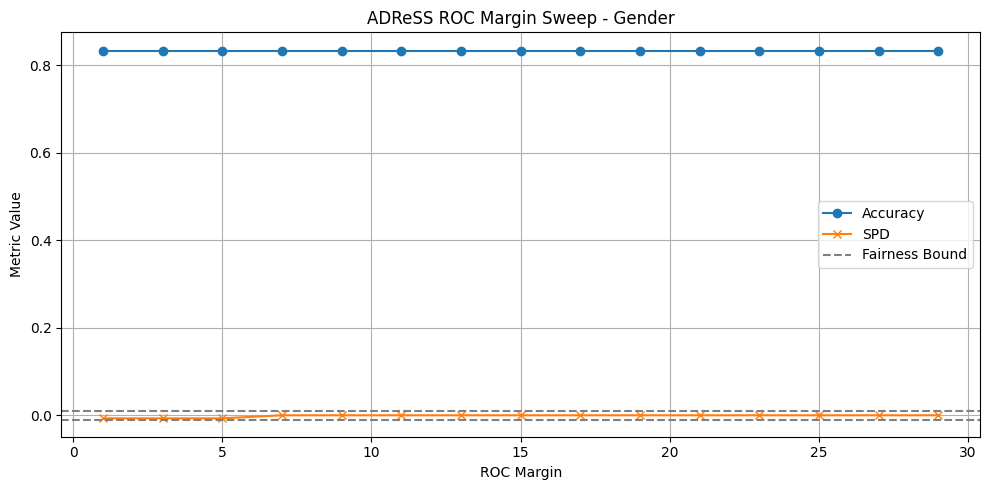


Fairness Metrics for AGE 65+:
    Accuracy before ROC:           0.833
    Accuracy after ROC:            0.750
    Statistical Parity Difference: 0.000
    Equal Opportunity Difference:  0.133
    Average Odds Difference:       -0.000
    Disparate Impact:              1.000


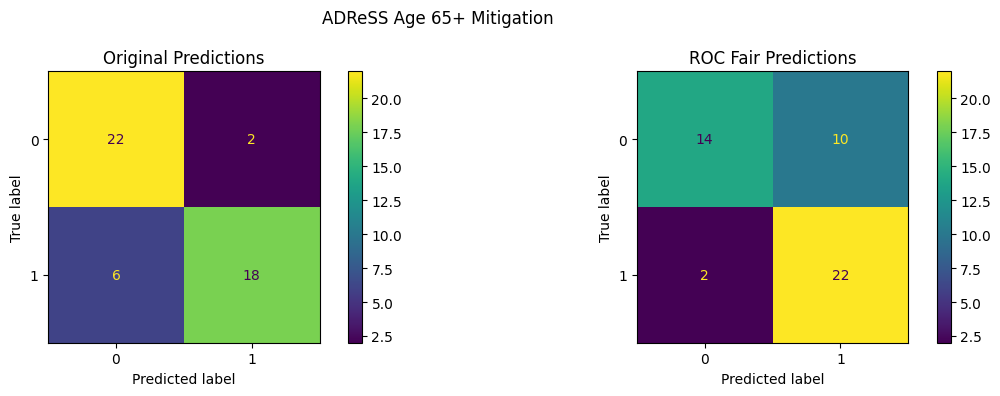

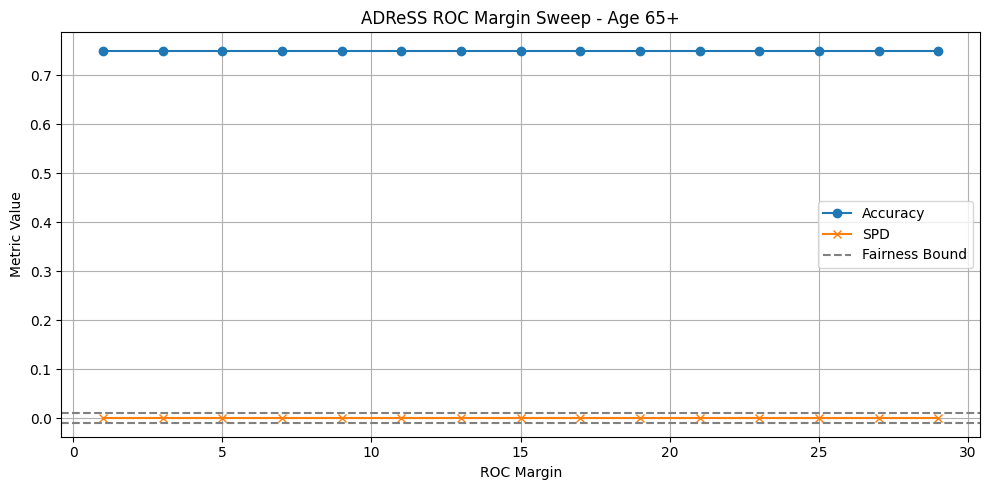

In [13]:
df_roc = run_roc_fairness_adress()